In [1]:
from datetime import datetime

import librosa.display
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import random


# 1. 資料加載與標記

In [2]:
def load_segmented_files(directory, target_sr=4800):
    wav_files = []
    leak_wav_files = []
    print(f"共有 {len(os.listdir(directory))} 個資料夾")
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        print(f"正在處理 {dir} 資料夾，共有 {len(os.listdir(os.path.join(directory, dir)))} 個檔案")
        for file in tqdm(os.listdir(os.path.join(directory, dir))):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None, mono=True)
            if sr != target_sr:
                    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            filename = f'{dir}_{file}'
            # y_filt = bandpass_filter(y, sr=target_sr, lowcut=10, highcut=1500)
            if 'Leak' in dir:
                leak_wav_files.append((y, target_sr, filename))
            else:
                wav_files.append((y, target_sr, filename))
    print(f"共有 {len(wav_files) + len(leak_wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files 



# 比較數量，均衡資料
def balance_shuffle_data(wav_files, leak_wav_files):
    min_count = min(len(wav_files), len(leak_wav_files))
    wav_files = random.sample(wav_files, min_count)
    leak_wav_files = random.sample(leak_wav_files, min_count)
    
    print(f"均衡後的樣本數: {min_count}")
    return wav_files, leak_wav_files


def create_dataset(directory):
    wav_files, leak_wav_files = load_segmented_files(directory)
    wav_files, leak_wav_files = balance_shuffle_data(wav_files, leak_wav_files)
    
    # 將資料轉為 NumPy 格式
    X = []
    y = []
    
    for audio, sr, filename in wav_files:
        X.append((audio, sr))
        y.append(0)  # wav_files 標記為 0
    
    for audio, sr, filename in leak_wav_files:
        X.append((audio, sr))
        y.append(1)  # leak_wav_files 標記為 1
    
    return np.array(X, dtype=object), np.array(y)


# 2. 特徵提取與資料預處理

In [3]:
from tqdm import tqdm
from data_preprocess import extract_features, extract_stft_features

def preprocess_data(X, desired_time=2.0, n_fft=2048, hop_length=512):
    features = []
    for audio, sr in tqdm(X):
        feature = extract_stft_features(audio, sr, desired_time=desired_time, n_fft=n_fft, hop_length=hop_length)
        # feature = extract_features(audio, sr, desired_time=desired_time, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        features.append(feature)
    return np.array(features)


In [4]:
def create_training_data(X,y, desired_time=2.0, n_fft=2048, hop_length=512):
    
    print(f"總樣本數: {len(X)}")
    print(f"標籤分佈: {np.bincount(y)}")
    
    
    X_features = preprocess_data(X, desired_time=desired_time, n_fft=n_fft, hop_length=hop_length)
    
    print(f"特徵形狀: {X_features.shape}")  # 預期形狀: (樣本數, max_len, n_mels)
    
    # 正規化特徵
    X_features = (X_features - np.mean(X_features)) / np.std(X_features)
    
    # 擴展維度以符合 CNN 輸入 (樣本數, 高, 寬, 通道)
    X_features = np.expand_dims(X_features, -1)  # 新形狀: (樣本數, max_len, n_mels, 1)
    
    # 分割訓練集與測試集
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2)
    
    print(f"訓練集形狀: {X_train.shape}")
    print(f"測試集形狀: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [6]:
X, y = create_dataset('raw_train')

共有 5 個資料夾
正在處理 CurrentSound 資料夾，共有 2429 個檔案


100%|██████████| 2429/2429 [01:37<00:00, 24.94it/s]


正在處理 Environment 資料夾，共有 588 個檔案


100%|██████████| 588/588 [00:31<00:00, 18.43it/s]


正在處理 GAS 資料夾，共有 99 個檔案


100%|██████████| 99/99 [00:08<00:00, 11.89it/s]


正在處理 Leak 資料夾，共有 3629 個檔案


100%|██████████| 3629/3629 [02:45<00:00, 21.88it/s]


正在處理 TrafficSound 資料夾，共有 129 個檔案


100%|██████████| 129/129 [00:06<00:00, 18.96it/s]

共有 6874 個 wav 檔案，其中 3629 個有泄漏，3245 個沒有泄漏
均衡後的樣本數: 3245


In [12]:
X_train, X_test, y_train, y_test = create_training_data(X, y, desired_time=2.0, n_fft=512, hop_length=64)

總樣本數: 6490
標籤分佈: [3245 3245]


100%|██████████| 6490/6490 [00:08<00:00, 730.55it/s] 


特徵形狀: (6490, 152, 257)
訓練集形狀: (5192, 152, 257, 1)
測試集形狀: (1298, 152, 257, 1)


# 3. 建立 CNN 模型

In [7]:
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    input_img = tf.keras.layers.Input(shape=input_shape)
 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_img, outputs=x)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [8]:
def create_model(mockup_input):    
    # 建立模型
    input_shape = (mockup_input.shape[1], mockup_input.shape[2], 1)
    print(f"模型輸入形狀: {input_shape}")
    model = create_cnn_model(input_shape)
    model.summary()
    return model

# 4. 訓練模型

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def train_model(model, X_train, X_test, y_train, y_test, epochs=30, batch_size=32):
        # 訓練模型
        
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
        
    history = model.fit(   
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, reduce_lr],
        verbose=2
    )
    
    # 評估模型
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    
    return model, history

In [10]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")

In [13]:
cnn_model = create_model(X_train)

模型輸入形狀: (152, 257, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 152, 257, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 152, 257, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 76, 129, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 76, 129, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 129, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 65, 32)       0         
 2D)                                   

In [14]:
model, history = train_model(cnn_model, X_train, X_test, y_train, y_test, epochs=120)

Epoch 1/120
163/163 - 10s - loss: 0.5322 - accuracy: 0.7477 - val_loss: 0.4626 - val_accuracy: 0.8089 - lr: 0.0010 - 10s/epoch - 64ms/step
Epoch 2/120
163/163 - 5s - loss: 0.4361 - accuracy: 0.8055 - val_loss: 0.4613 - val_accuracy: 0.8290 - lr: 0.0010 - 5s/epoch - 29ms/step
Epoch 3/120
163/163 - 5s - loss: 0.3934 - accuracy: 0.8205 - val_loss: 0.3650 - val_accuracy: 0.8490 - lr: 0.0010 - 5s/epoch - 29ms/step
Epoch 4/120
163/163 - 5s - loss: 0.3700 - accuracy: 0.8399 - val_loss: 0.3801 - val_accuracy: 0.8413 - lr: 0.0010 - 5s/epoch - 29ms/step
Epoch 5/120
163/163 - 5s - loss: 0.3390 - accuracy: 0.8453 - val_loss: 0.2969 - val_accuracy: 0.8821 - lr: 0.0010 - 5s/epoch - 30ms/step
Epoch 6/120
163/163 - 5s - loss: 0.3169 - accuracy: 0.8582 - val_loss: 0.3422 - val_accuracy: 0.8690 - lr: 0.0010 - 5s/epoch - 31ms/step
Epoch 7/120
163/163 - 5s - loss: 0.3042 - accuracy: 0.8679 - val_loss: 0.2712 - val_accuracy: 0.8906 - lr: 0.0010 - 5s/epoch - 29ms/step
Epoch 8/120
163/163 - 5s - loss: 0.3003

In [15]:
evaluate_model(cnn_model, X_test, y_test)

41/41 [==============================] - 1s 14ms/step - loss: 0.2343 - accuracy: 0.9060
Test loss: 0.2343
Test accuracy: 0.91


In [16]:
date = datetime.now().strftime('%Y%m%d%H%M')
val_acc = history.history['val_accuracy'][-1]
model.save(f'model_mel_{date}_stft_acc_{val_acc:.2f}.h5')
print(f"Model saved as model_stft_{date}_acc_{val_acc:.2f}.h5")

Model saved as model_stft_202411121625_acc_0.92.h5


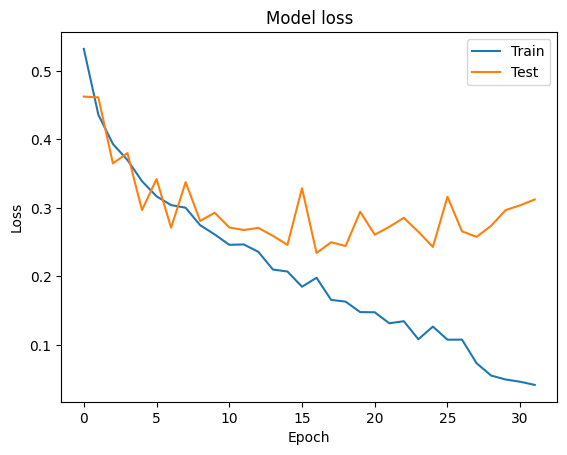

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(f'model_stft_loss_{date}_acc_{val_acc:.2f}.png')
plt.show()